# Batch normalization

La "Batch Norm" est une technique de régularisation qui va permettre d'avoir des ordres de grandeurs équivalents pour les entrées d'une fonction d'activation.

## Analyse en composantes principales

L'analyse en composantes principales (Principal component analysis) est une technique de pré-traitement des données qui transforme des variables liées entre elles en variables décorrélées et de même ordre de grandeur. Anciennenement utilisé en traitement des données envoyées dans les réseaux pour faciliter leur convergence.

Voici un exemple simple des manipulations à effectuer dans le cas de deux variables.

Création d'une population de 40 individus ayant deux caractéristiques A et B

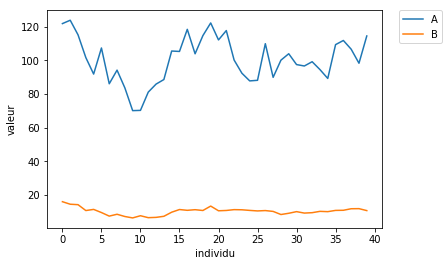

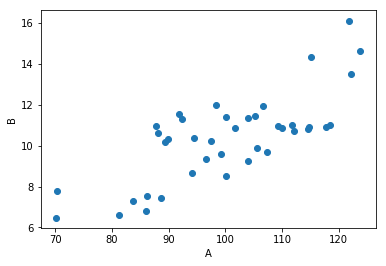

In [1]:
from random import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

A = []
B = []
for i in range(40):
    y = np.exp(-i/20.) * np.cos(2*np.pi*i/20.)
    # Génération des valueurs de A et B
    a = 100 + 30 * y
    b = 10 + 5 * y
    # Ajout d'un bruit de +/- 30%
    a = a * (1+(random()-0.5)*0.3)
    b = b * (1+(random()-0.5)*0.3)
    A.append(a)
    B.append(b)

def visualisation(A,B, labelA, labelB):
    plt.plot(A, label=labelA)
    plt.plot(B, label=labelB)
    plt.xlabel('individu')
    plt.ylabel('valeur')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()
    plt.scatter(A,B)
    plt.xlabel(labelA)
    plt.ylabel(labelB)
    plt.show()

visualisation(A,B,'A','B')

Si on a un jeu de données de ce type et que l'on cherche à créer un réseau de neurones basé sur ces éléments avec un vecteur d'entrée qui comporte $[A,B]$ , on se heurte au problème d'avoir de très mauvaises données en entrée. Les ordres de grandeurs ne sont pas du tout similaires entre les caractéristiques A et B. Lors du passage dans un neurone comme on multiplie l'entrée par un poids w, l'activation sera bien plus importante lorsque la valeur d'entrée sera grande. Ce qui créé des déséquilibres dans le réseau neuronal et entraîne une perte d'efficacité.

Pour ramener les jeux de données à des ordres de grandeurs similaires et les centrer autour de zéro: on soustrait la moyenne et on divise par l'écart type.

$$\hat{A} = \frac{A - mean(A)}{std(A)}$$

En notation mathématique:

$$\hat{A} = \frac{A - \overline{A}}{\sigma_A}$$

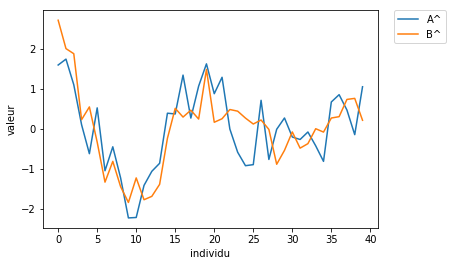

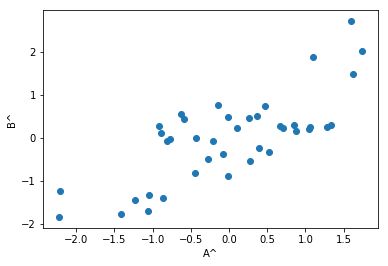

In [2]:
import pandas as pd
df = pd.DataFrame()
df['A'] = A
df['B'] = B
df.A = (df.A - df.A.mean())/df.A.std()
df.B = (df.B - df.B.mean())/df.B.std()
visualisation(df.A, df.B,'A^','B^')

En faisant cette opération, on remarque que les variables semblent corrélées car elle évoluent de façon similaire (et le nuage de points de B en fonction de A s'oriente principalement selon une diagonale).

On suppose qu'il y de l'information à exploiter dans ces signaux, mais pour que le réseau soit efficace il faut que les variables d'entrée soient décorrélées (en tous cas que la corrélation ne soit pas évidente et que le nuage de points soit réparti de façon homogène). Pour cela on va suivre l'évolution des variables:

$$A' = ( \hat{A} + \hat{B}) / 2$$

$$B' = \hat{A} - \hat{B}$$

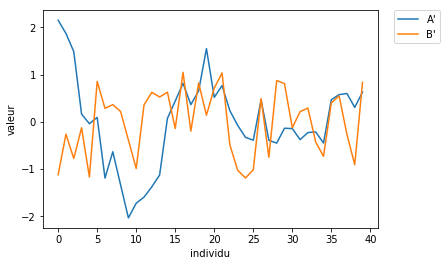

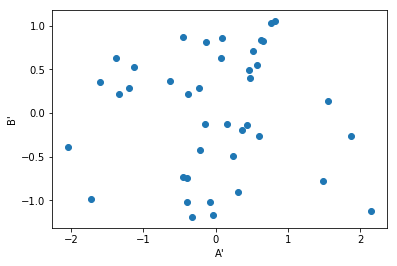

In [3]:
df['A_'] = (df.A + df.B)/2
df['B_'] = df.A - df.B
visualisation(df.A_, df.B_,'A\'','B\'')

Le nuage de points est maintenant homogène et peut servir d'entrée à notre réseau. On parle de "data whitening" car il transforme le vecteur d'entrée en l'équivalent d'un bruit blanc.

Ces actions correspondents à un ensemble d'opérations matricielles sur notre vecteur de départ: homothétie, translation et rotation.

$$
\begin{bmatrix}
A'\\
B'
\end{bmatrix} = 
\begin{bmatrix}
1.2 & 0.3\\
4.5 & -1.2
\end{bmatrix}\begin{bmatrix}
A\\
B
\end{bmatrix}
+
\begin{bmatrix}
-0.5\\
-0.1
\end{bmatrix}
$$

Cette technique est généralisable pour une entrée à n dimensions.

## Ajout d'une couche au réseau pour se charger de la régularisation

Notre vecteur X' en fonction de X ressemble précisément à l'opération qui se fait dans une couche d'un réseau de neurones où $X' = WX + B$. Avec la baisse du coût de temps de calcul au lieu de préparer les données mathématiquement avec l'analyse en composantes principales, on va charger une couche additionnelle du réseau de neurones de s'occuper de cette régularisation.

Dans ce cas, une première couche fait l'adaptation des données selon l'algorithme de la batch norm et la suivante fait le vrai travail. 

## Algorithme de la batch norm pour un neurone

On suppose que l'on travaille sur un mini batch B de taille m pour une caractérisque x en entrée, $B=\{x_{1\ldots m}\}$. Le but est de régulariser les données d'entrées sur le mini batch.

On cherche à apprendre pour chaque neurone deux paramètres: $\gamma$,$\beta$

En sortie on a $y_i =  BN_{\gamma,\beta}(x_i)$

Moyenne sur le mini batch: $$\mu \leftarrow \frac{1}{m} {\sum\limits_{j=1}^{m}x_j}$$

Variance sur le mini batch (= carré de l'écart type): $$\sigma^2 \leftarrow \frac{1}{m} {\sum\limits_{j=1}^{m}(x_j-\mu)^2}$$

Normalisation ($\epsilon$ petite valeur qui sert à éviter les divisions par zéro): $$\hat{x_j} \leftarrow \frac{x_j -\mu}{\sqrt{\sigma^2 + \epsilon}}$$

Mise à l'échelle et déplacement: $$y_j \leftarrow  \gamma\hat{x_j} + \beta =BN_{\gamma,\beta}(x_i)$$

Le problème est qu'il faudrait dédoubler chaque couche de notre réseau pour que les données en entrée soient à chaque fois régularisées, le coût deviendrait trop important.

## Batch norm en réalité

Les deux étapes BN et couche avec activation sont rassemblées au lieu de faire deux couches disjointes.

### Cas classique

Pour une couche du réseau neuronal avec un mini batch en entrée

$$Y = activation(X.W + B)$$

> Dimensions:
> - $Y[batch, neurones]$ où $batch$ est le nombre d'éléments dans le batch et $neurones$ le nombre de neurones dans la couche considérée
> - $X[batch, entrées]$ où $entrées$ est le nombre d'éléments dans le vecteur en entrée
> - $W[entrées, neurones]$
> - $B[neurones]$ (addition broadcasting)

### Cas avec batch norm

L'idée principale est de combiner les neurones avec batch norm à ceux avec la fonction d'activation. On va appliquer la batch norm sur les logits juste avant de les faire passer dans la fonction d'activation.

On suppose que l'on travaille sur un mini batch B de taille m pour une entrée $X[m]$, $B=\{X_{1\ldots m}\}$

Pour chaque neurone on fait les actions suivantes:

Calcul des logits $Z[m]$: $$Z=X.W+B$$

Mise à l'échelle (logits rescaling) $\hat{Z}[m]$: $$\hat{z}_i = \frac{z_i - \overline{Z}}{\sqrt{\sigma_Z^2+\epsilon}}$$


Ajout de deux degrés de liberté à mon neurone: $\gamma, \beta$. Ces deux facteurs sont destinés à être appris lors de l'entraînement (respectivement learnable scale et offset).  $Z'[m]$ $$z'_i =  \gamma\hat{z}_i + \beta =BN_{\gamma,\beta}(\hat{z}_i)$$

Et on ne perd pas le cas antérieur à cette manipulation, il suffit que le réseau apprenne $\gamma = \sigma_Z$ et $\beta= \overline{Z}$.

C'est cette valeur que l'on va envoyer dans la fonction d'activation (sigmoïde ou relu), et donc on aura en sortie $Y[100]$ $$Y = activation(Z')$$

Par neurone on va devoir apprendre $w_1, ..., w_n, b, \gamma, \beta$ (chaque vecteur $X_i$ ayant n valeurs). Cela reste possible car la fonction $BN_{\gamma,\beta}(\hat{z}_i)$ est dérivable par rapport aux poids, biais, $\gamma$,et $\beta$

Par rapport à l'analyse en composantes principales, on en fait pas la décorrélation, car c'est trop coûteux pour une efficacité trop faible.

## Paramètres de la batch norm

### Fonction d'activation

Cumuler les biais et $\beta$ est redondant, donc on se limite au paramètre $\beta$

On garde le paramètre $\gamma$ pour la sigmoïde, par contre pour relu on le supprime aussi. Autant dans le premier cas un changement d'échelle modifie la zone d'activation de la sigmoïde, autant pour relu cette mise à l'échelle n'a pas d'importance.

### Dropout

Il y a une certaine similarité des effets de la Batch norm et du dropout. Dans l'usage, soit on élimine complètemenet le dropout, soit on utilise un taux réduit.

### Phase de test

Durant la phase de test, on utilise les statistiques calculées sur la moyenne mobile exponentielle des n dernières itérations. Le calcul sur l'ensemble des valeurs du jeu de test est valide mais souvent trop chronophage.

### Convolution

Chaque neurone a une valeur:
- par image dans le batch
- par position x du filtre
- par position y du filtre

Il faut calculer les statistisques sur l'ensemble des valeurs `batchsize * width * height`. Par contre on a toujours $\gamma$ et $\beta$ par neurone